In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
from src.training.utils import losses
from src.training.utils import one_hot
import numpy as np
import shap
import tensorflow as tf
from src.evaluation.interpret import shap_utils
tf.compat.v1.disable_eager_execution()
from src.evaluation.interpret import viz_sequence
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
data = pd.read_csv("pPPIF_Motif_Insertions_2022-03-14_V3.csv").dropna(how="all").dropna(axis=1,how="all")

In [3]:
data.head()

N     Motif        Edit_Type Insertion_Sequence  \
0  0.0  WildType         WildType                NaN   
1  1.0       YY1  Consensus_Motif           AAGATGGC   
2  2.0     GABPA  Consensus_Motif           ACCGGAAG   
3  3.0      ETS1  Consensus_Motif           CAGGAAGT   
4  4.0       NFY  Consensus_Motif           CCAATCAG   

  Insertion_hg19_coordinate            Spacer_Seq       Spacer_Coordinates  \
0                       NaN                   NaN                      NaN   
1   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   
2   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   
3   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   
4   chr10:81107166-81107167  GCCTGGAGGAGGCGGGACGG  chr10:81107148-81107167   

                                    Mapping_Seq_2114  
0  TCACAGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCT...  
1  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...  
2  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...  
3  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...  
4  AGATGCCCACAGGCACAGTACTTAGTTGACAAATCCATGTCTCTCT...

In [4]:
def load_model_wrapper(model_h5):
    # read .h5 model
    custom_objects={"MultichannelMultinomialNLL": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_h5)
    print("model loaded succesfully")
    return model

In [5]:
model = load_model_wrapper("/oak/stanford/groups/akundaje/anusri/THP1-Engreitz/results/chrombpnet/ATAC_PE/ATAC_PE_03.24.2022_withgm12878bias/chrombpnet_model/chrombpnet_wo_bias.h5")

model loaded succesfully


In [6]:
inputs = one_hot.dna_to_one_hot(data["Mapping_Seq_2114"].values)

In [7]:
print(inputs.shape)

(43, 2114, 4)


In [8]:
output_preds = model.predict(inputs)

/users/anusri/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [9]:
def interpret(model, seqs, profile_or_counts):
    print("Seqs dimension : {}".format(seqs.shape))

    outlen = model.output_shape[0][1]

    profile_model_input = model.input
    profile_input = seqs
    counts_model_input = model.input
    counts_input = seqs

    if "counts" in profile_or_counts:
        profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
            (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'counts' shap scores")
        counts_shap_scores = profile_model_counts_explainer.shap_values(
            counts_input, progress_message=100)

        #counts_scores_dict = generate_shap_dict(seqs, counts_shap_scores)

    if "profile" in profile_or_counts:
        weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
        profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
            (profile_model_input, weightedsum_meannormed_logits),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'profile' shap scores")
        profile_shap_scores = profile_model_profile_explainer.shap_values(
            profile_input, progress_message=100)

        #profile_scores_dict = generate_shap_dict(seqs, profile_shap_scores)

    return counts_shap_scores, profile_shap_scores


In [10]:
counts_scores_dict, profile_scores_dict = interpret(model, inputs, ["profile", "counts"])

Seqs dimension : (43, 2114, 4)

Generating 'counts' shap scores
Done 0 examples of 43


Using TensorFlow backend.


Generating 'profile' shap scores
Done 0 examples of 43


In [11]:
counts_scores = counts_scores_dict*inputs
profile_scores = profile_scores_dict*inputs

In [12]:
odir="/oak/stanford/groups/akundaje/anusri/THP1-Engreitz/results/chrombpnet/ATAC_PE/ATAC_PE_03.24.2022_withgm12878bias/predictions_at_loci_flank_150/"

In [13]:
input_length=2114
flank=150


def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)
probs = softmax(output_preds[0])




In [14]:
values = []
names = []
for idx in range(len(data["Motif"].values)):
    if idx==0:
        continue
        
    values.append((output_preds[1][idx]-output_preds[1][0])[0])
    names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

In [15]:
sorted_dix  = np.argsort(names)

In [16]:
np.array(values)[sorted_dix].tolist()

[0.23155593872070312,
 0.05981731414794922,
 0.07031488418579102,
 0.0966339111328125,
 0.2633800506591797,
 0.2076573371887207,
 0.038127899169921875,
 0.07771968841552734,
 0.15186023712158203,
 0.1129450798034668,
 0.15908193588256836,
 0.24291515350341797,
 0.06988239288330078,
 0.10947179794311523,
 -0.03826904296875,
 0.1617269515991211,
 0.08434772491455078,
 -0.059722900390625,
 0.04481029510498047,
 0.17812204360961914,
 -0.10619258880615234,
 0.04679679870605469,
 0.21003437042236328,
 0.0823063850402832,
 0.14645719528198242,
 0.040439605712890625,
 -0.011981487274169922,
 0.1149592399597168,
 0.13449478149414062,
 -0.0045032501220703125,
 0.16343975067138672,
 0.08219242095947266,
 0.015460968017578125,
 0.12726211547851562,
 -0.00732421875,
 0.17171859741210938,
 0.09152936935424805,
 0.25671863555908203,
 0.2798032760620117,
 0.1634502410888672,
 0.10367107391357422,
 -0.05664539337158203]

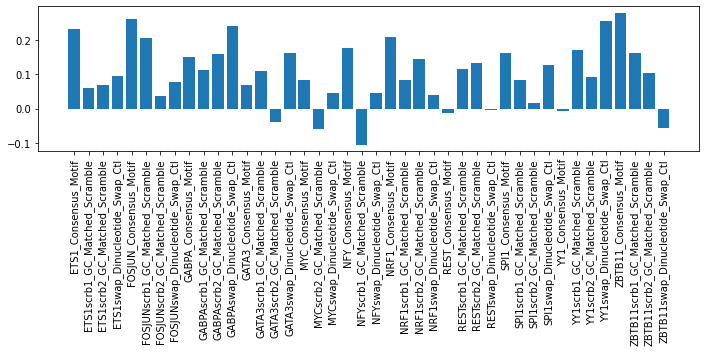

In [17]:
bars_label=np.array(names)[sorted_dix].tolist()
bars_heights=np.array(values)[sorted_dix].tolist()
plt.figure(figsize=(10,5))
plt.bar(range(len(bars_label)), bars_heights)
plt.xticks(range(len(bars_label)), bars_label, rotation='vertical')
plt.tight_layout()
plt.show()

In [18]:
from scipy.spatial import distance

def mysign(x):
    if x >= 0: 
        return 1
    else:
        return -1
    
jsd_values = []
jsd_names = []
for idx in range(len(data["Motif"].values)):
    if idx==0:
        continue
    #valt = np.sum(np.abs(np.log(probs[idx]) -  np.log(probs[0])))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])
    valt = (distance.jensenshannon(probs[0], probs[idx]))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])

    jsd_values.append(valt)
    jsd_names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

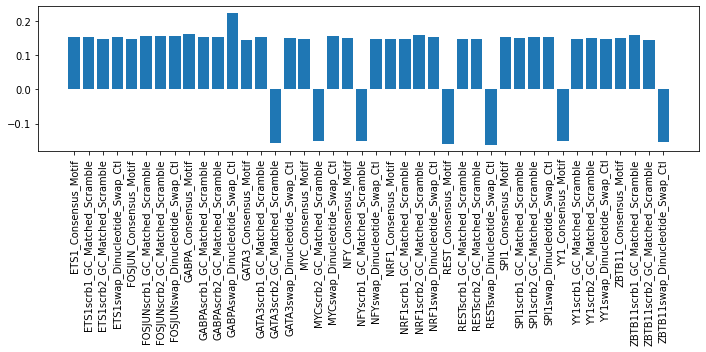

In [19]:
bars_label=np.array(jsd_names)[sorted_dix].tolist()
bars_heights=np.array(jsd_values)[sorted_dix].tolist()
plt.figure(figsize=(10,5))
plt.bar(range(len(bars_label)), bars_heights)
plt.xticks(range(len(bars_label)), bars_label, rotation='vertical')
plt.tight_layout()
plt.show()

WildType_WildType_flank_150.png
YY1_Consensus_Motif_flank_150.png
5.8964677
[-0.12422176]%
GABPA_Consensus_Motif_flank_150.png
5.8964677
[2.575428]%
ETS1_Consensus_Motif_flank_150.png
5.8964677
[3.9270198]%
NFY_Consensus_Motif_flank_150.png
5.8964677
[3.0208182]%
NRF1_Consensus_Motif_flank_150.png
5.8964677
[3.562021]%
SPI1_Consensus_Motif_flank_150.png
5.8964677
[2.771849]%
GATA3_Consensus_Motif_flank_150.png
5.8964677
[1.1851407]%
MYC_Consensus_Motif_flank_150.png
5.8964677
[1.4304708]%
FOSJUN_Consensus_Motif_flank_150.png
5.8964677
[4.466751]%
ZBTB11_Consensus_Motif_flank_150.png
5.8964677
[4.7452855]%
REST_Consensus_Motif_flank_150.png
5.8964677
[-0.20323005]%
YY1swap_Dinucleotide_Swap_Ctl_flank_150.png
5.8964677
[4.3537455]%
GABPAswap_Dinucleotide_Swap_Ctl_flank_150.png
5.8964677
[4.119648]%
ETS1swap_Dinucleotide_Swap_Ctl_flank_150.png
5.8964677
[1.638836]%
NFYswap_Dinucleotide_Swap_Ctl_flank_150.png
5.8964677
[0.7936493]%
NRF1swap_Dinucleotide_Swap_Ctl_flank_150.png
5.8964677
[0.

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZBTB11swap_Dinucleotide_Swap_Ctl_flank_150.png
5.8964677
[-0.96067464]%
RESTswap_Dinucleotide_Swap_Ctl_flank_150.png
5.8964677
[-0.07638817]%
YY1scrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[2.9122443]%
GABPAscrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[1.9154701]%
ETS1scrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[1.0144521]%
NFYscrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[-1.8009769]%
NRF1scrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[1.3958753]%
SPI1scrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[1.3939183]%
GATA3scrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[1.8565738]%
FOSJUNscrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[3.5217001]%
ZBTB11scrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[2.7719784]%
RESTscrb1_GC_Matched_Scramble_flank_150.png
5.8964677
[1.9496208]%
YY1scrb2_GC_Matched_Scramble_flank_150.png
5.8964677
[1.5522665]%
GABPAscrb2_GC_Matched_Scramble_flank_150.png
5.8964677
[2.6979113]%
ETS1scrb2_GC_Matched_Scramble_flank_150.png
5.896

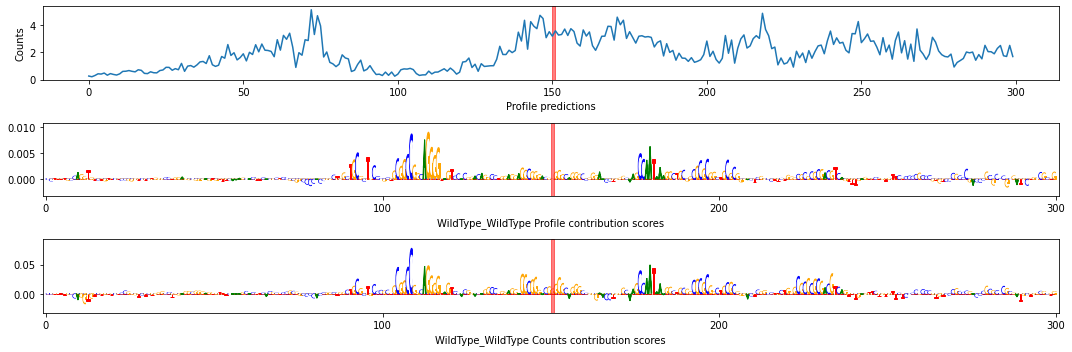

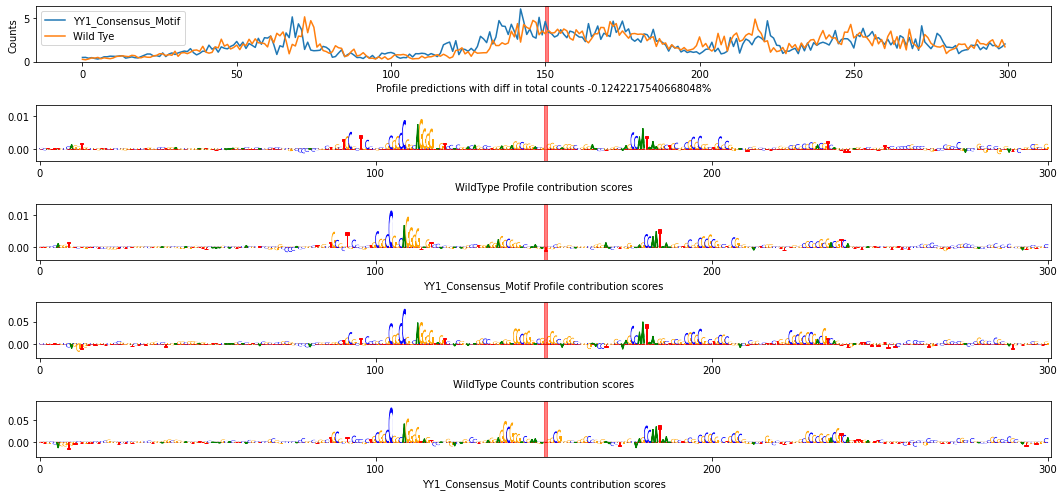

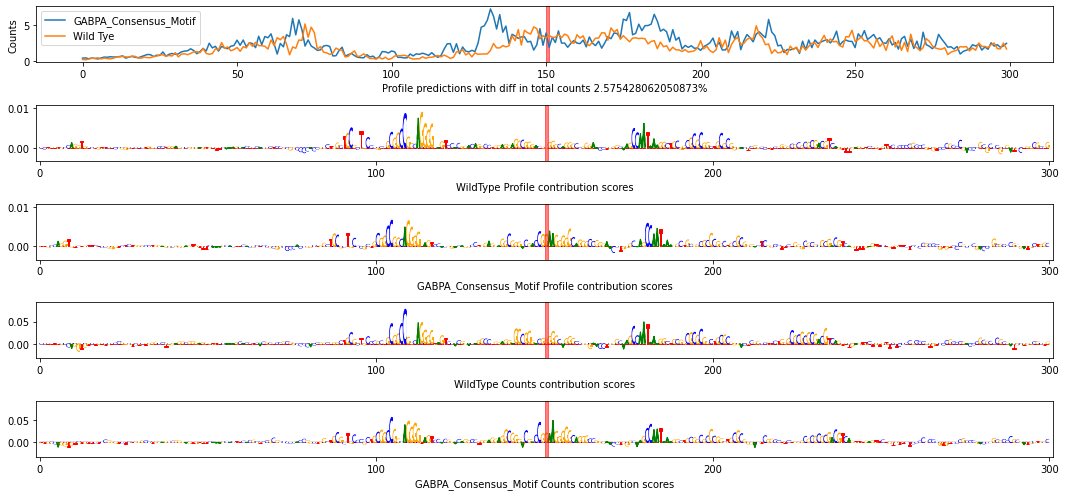

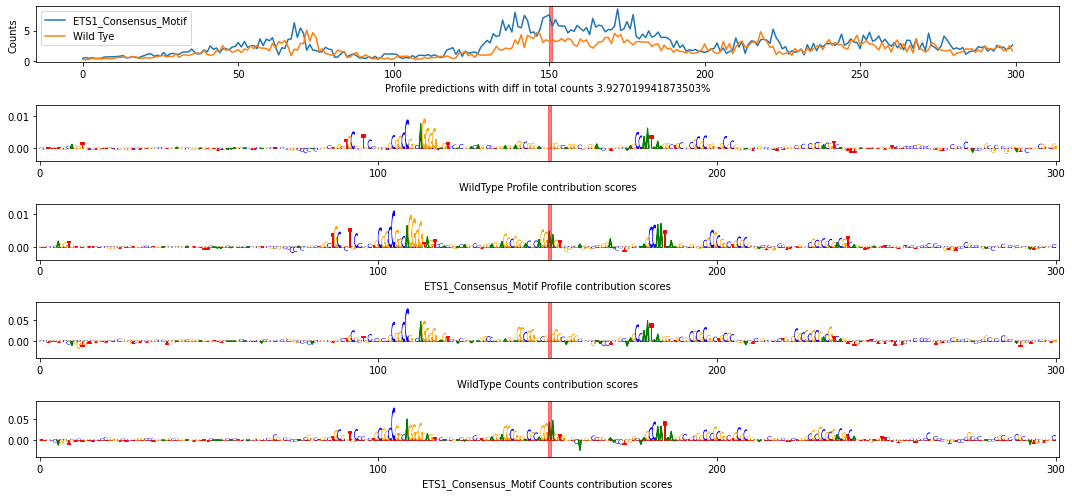

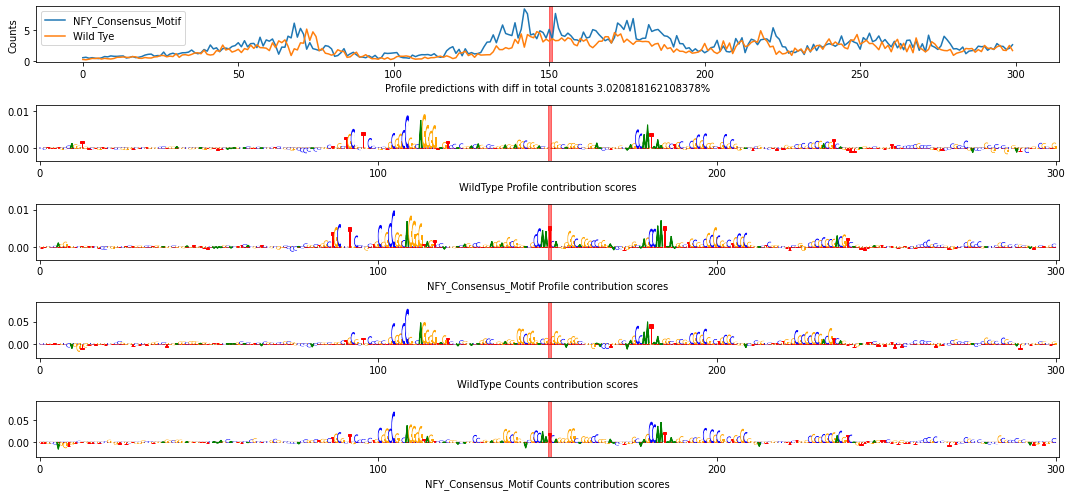

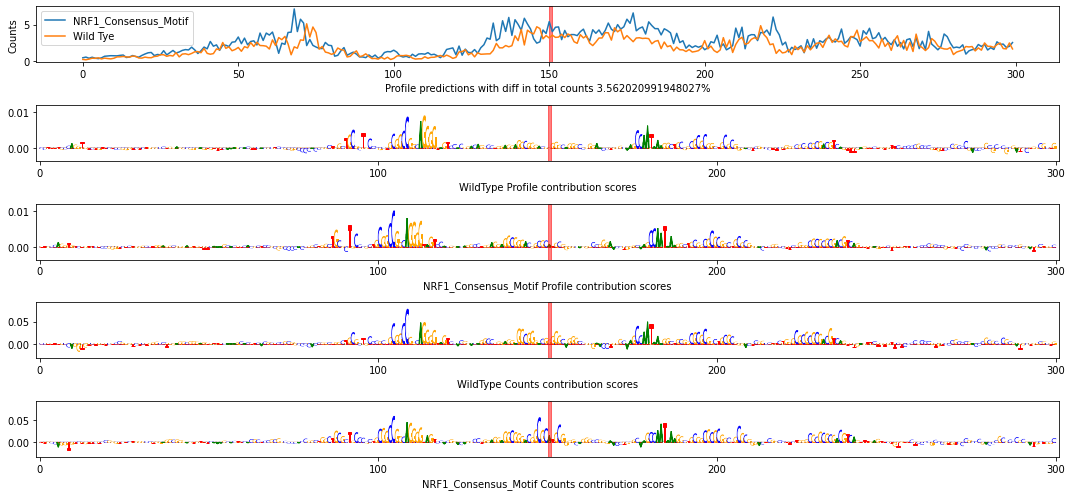

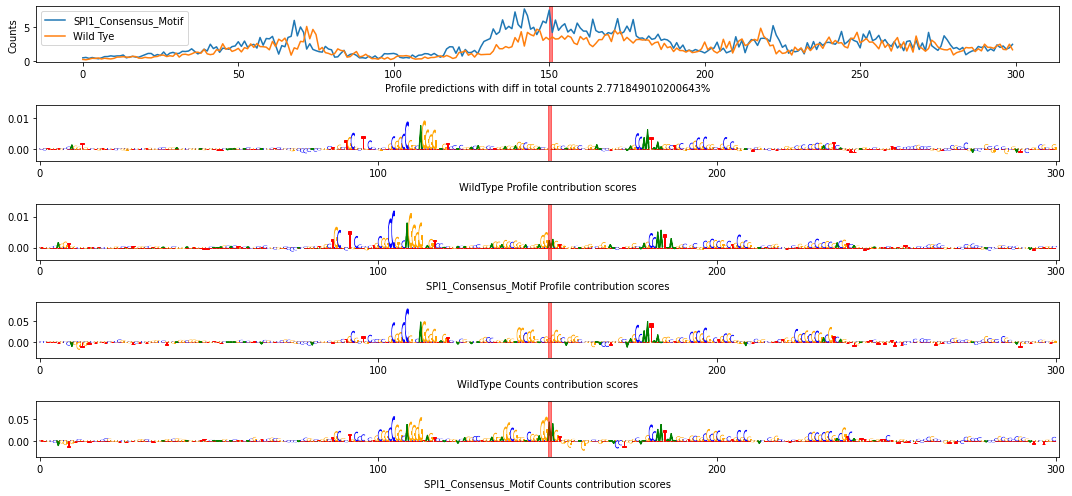

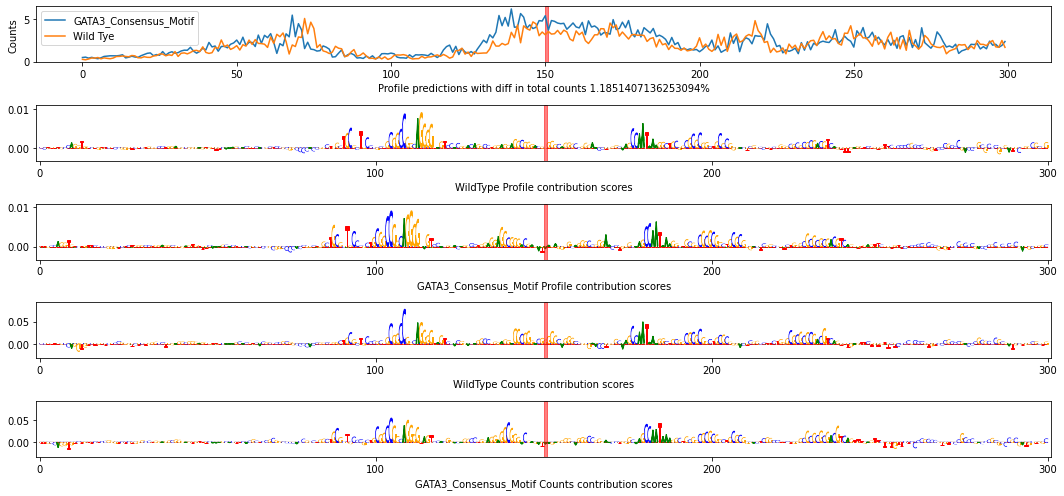

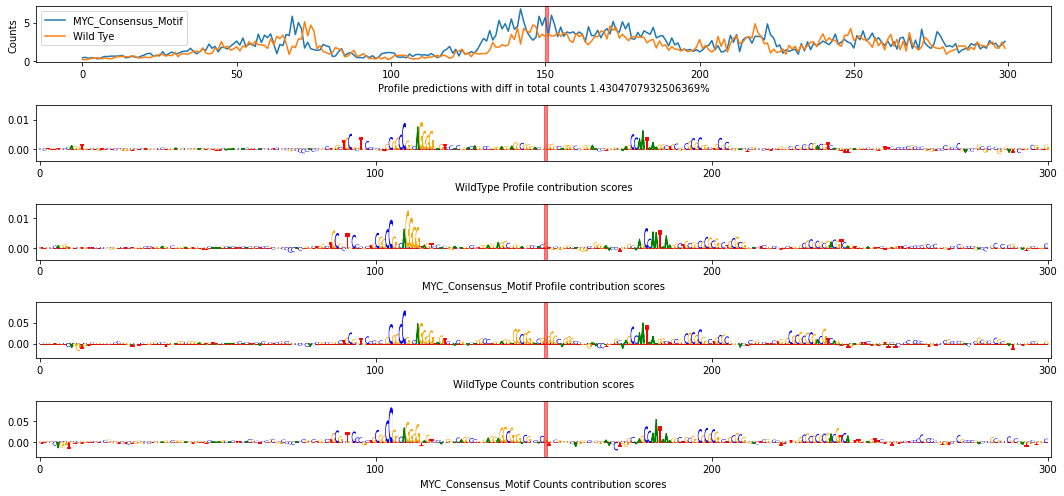

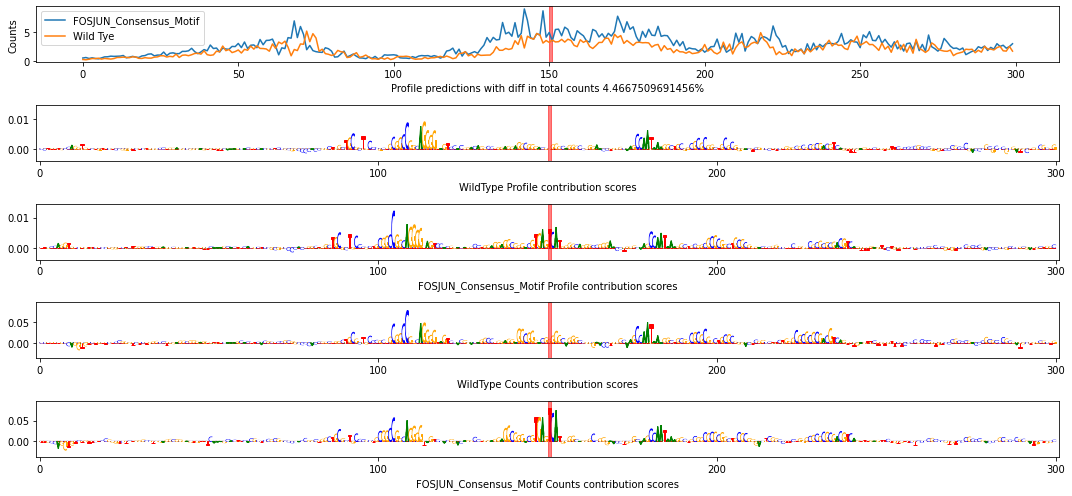

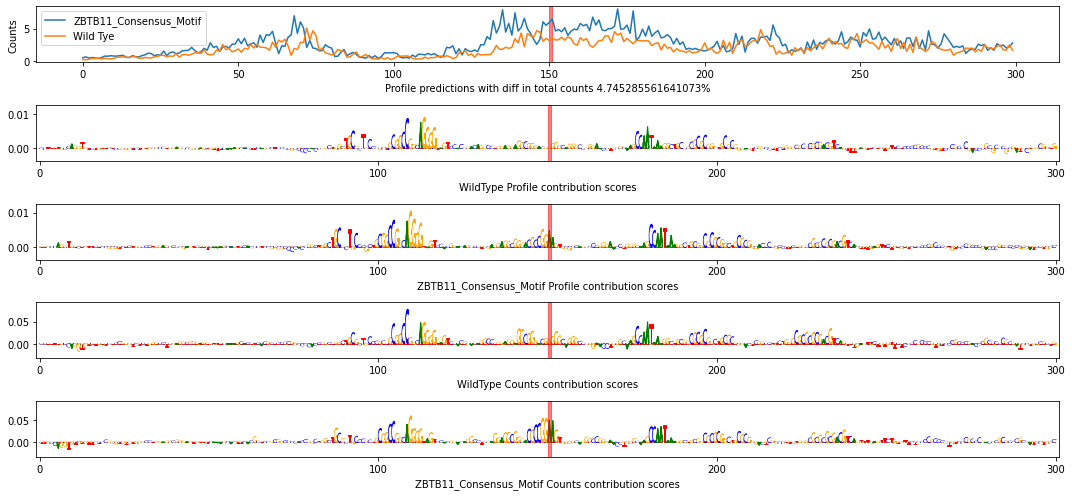

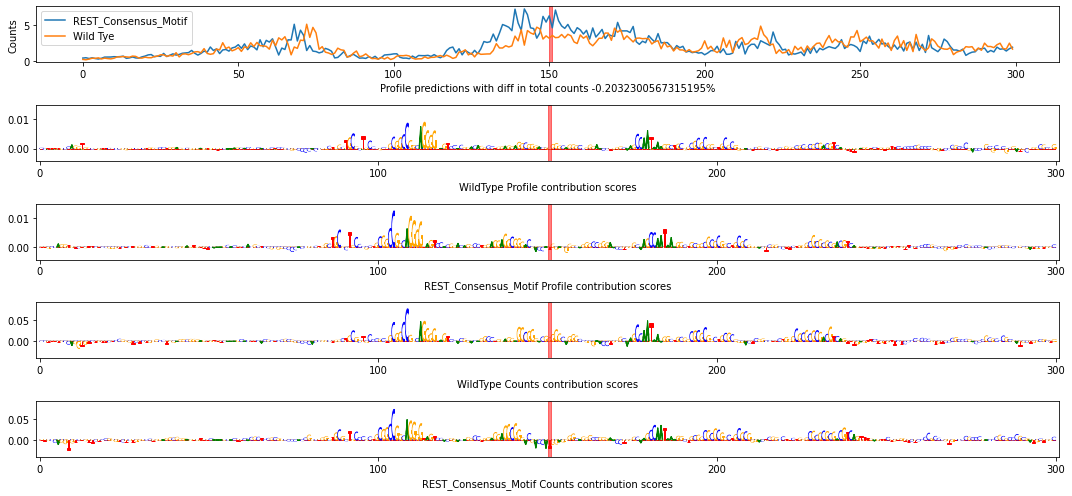

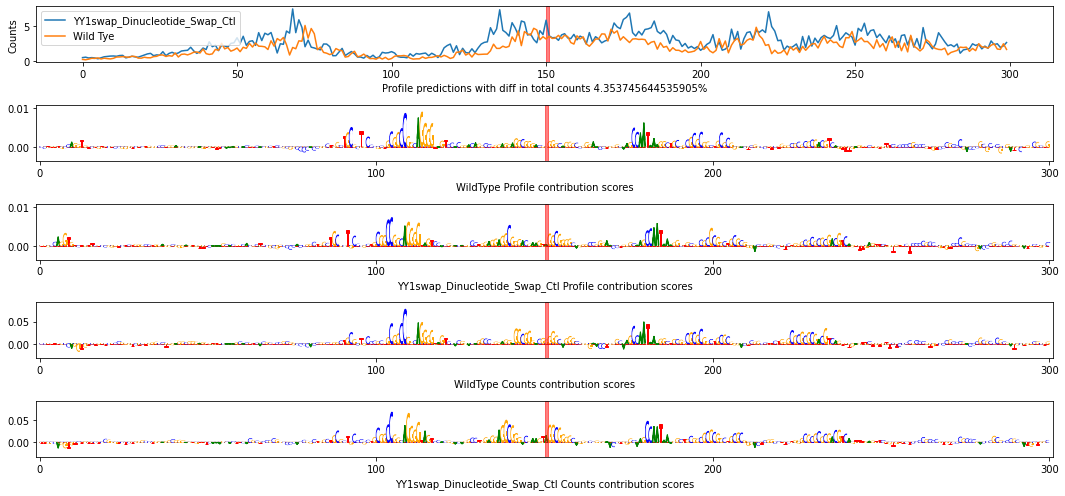

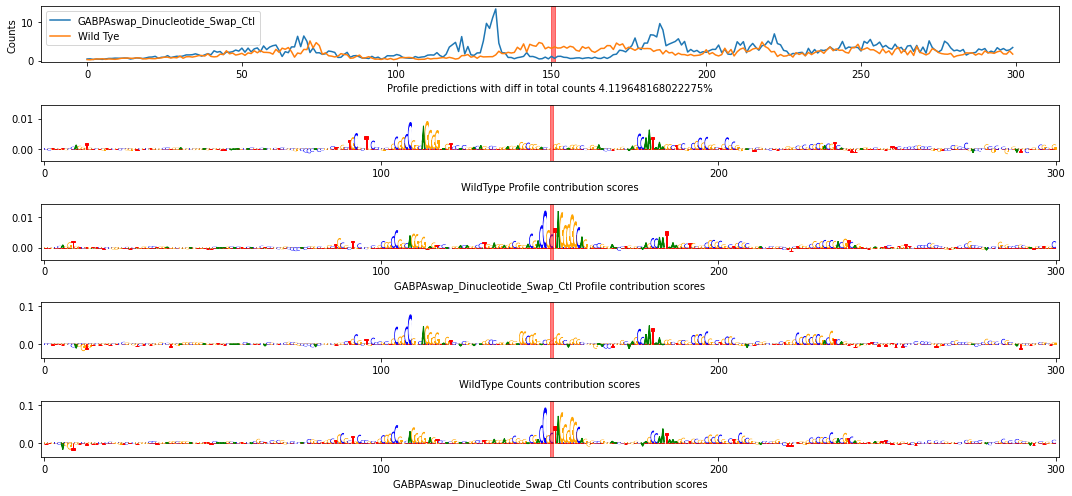

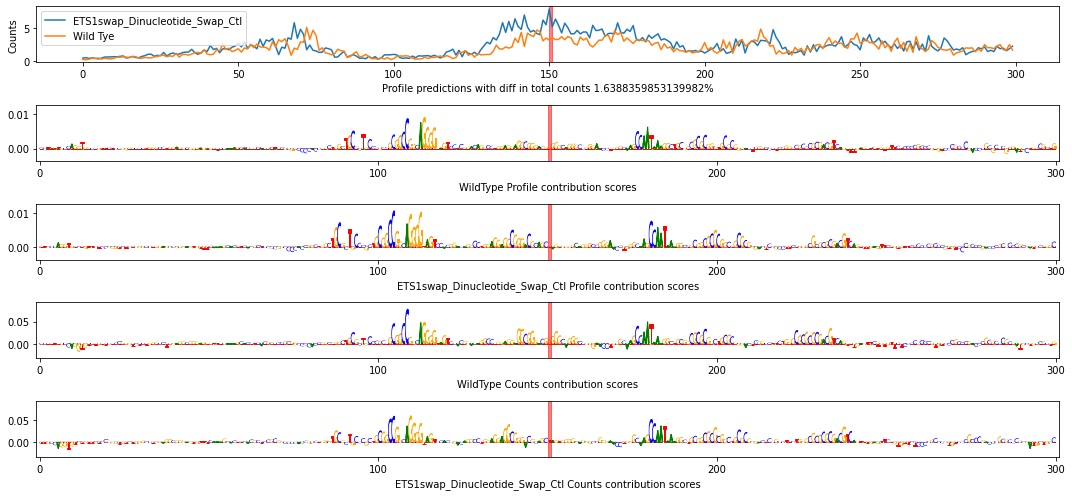

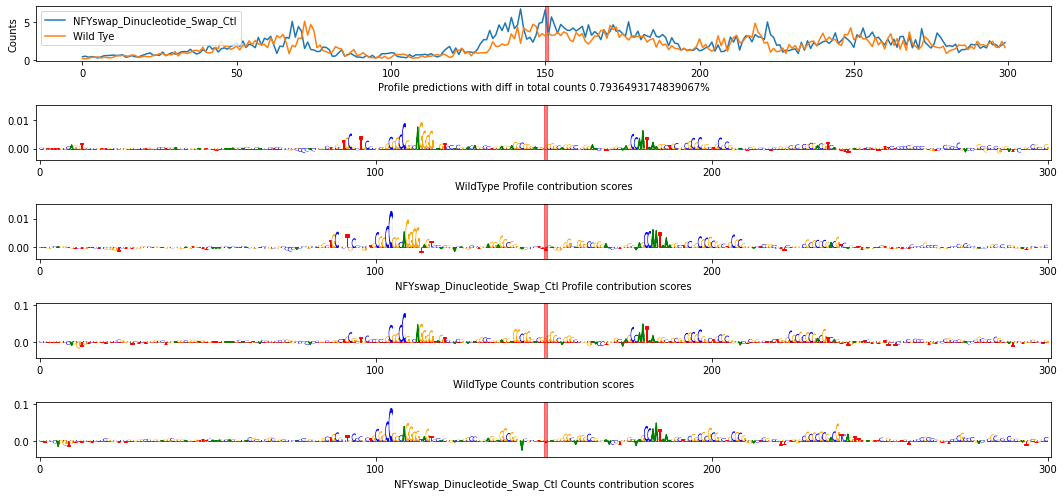

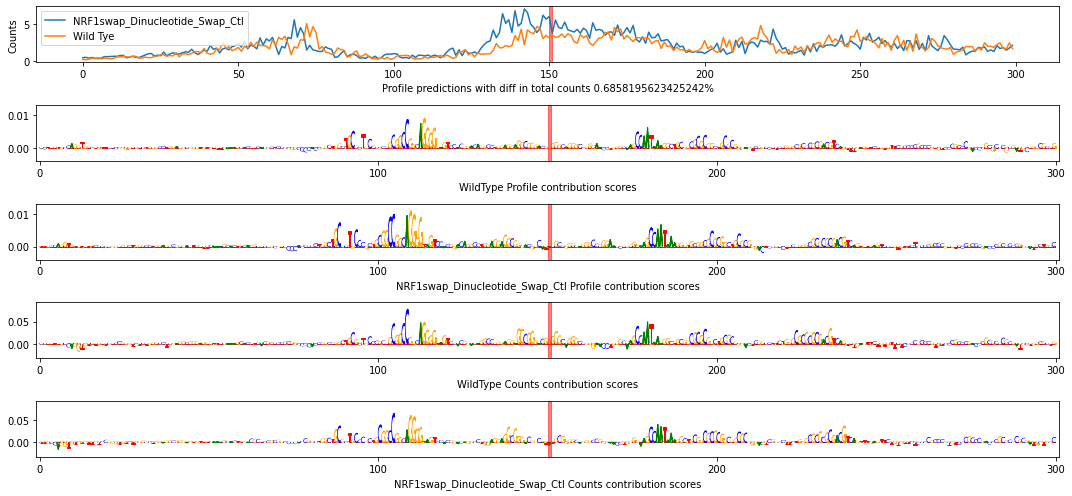

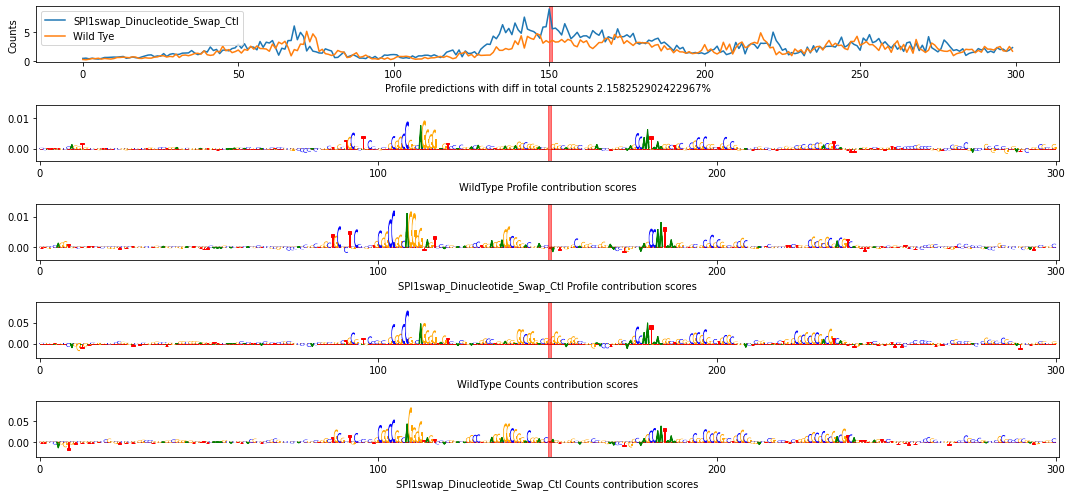

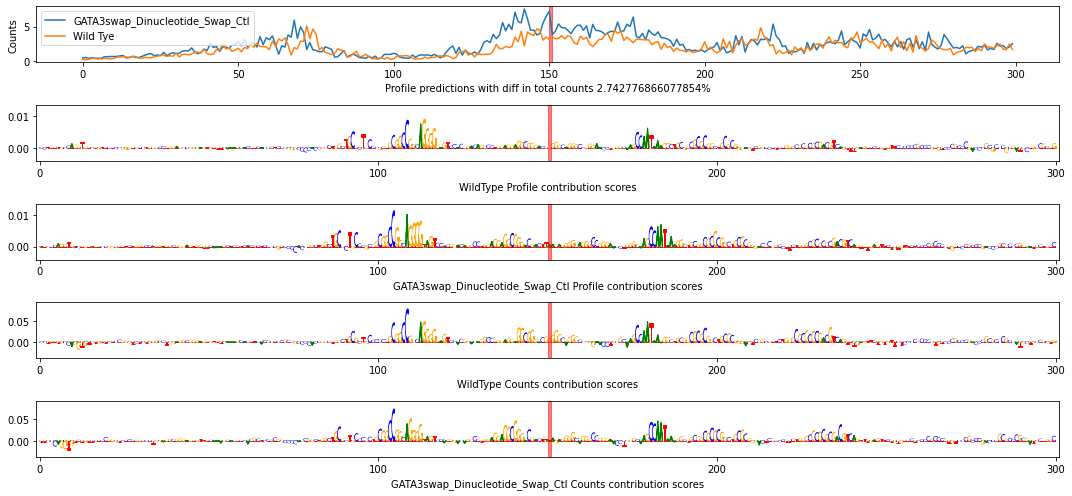

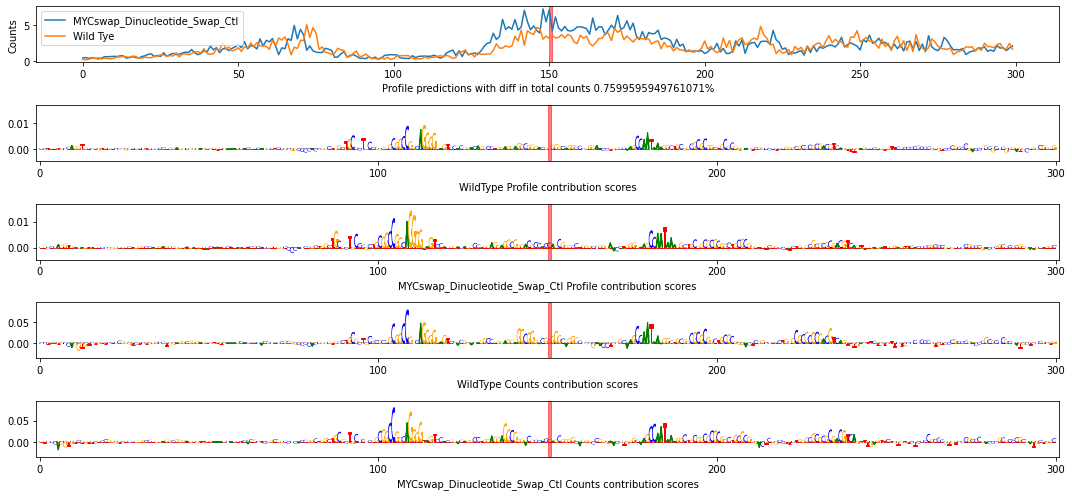

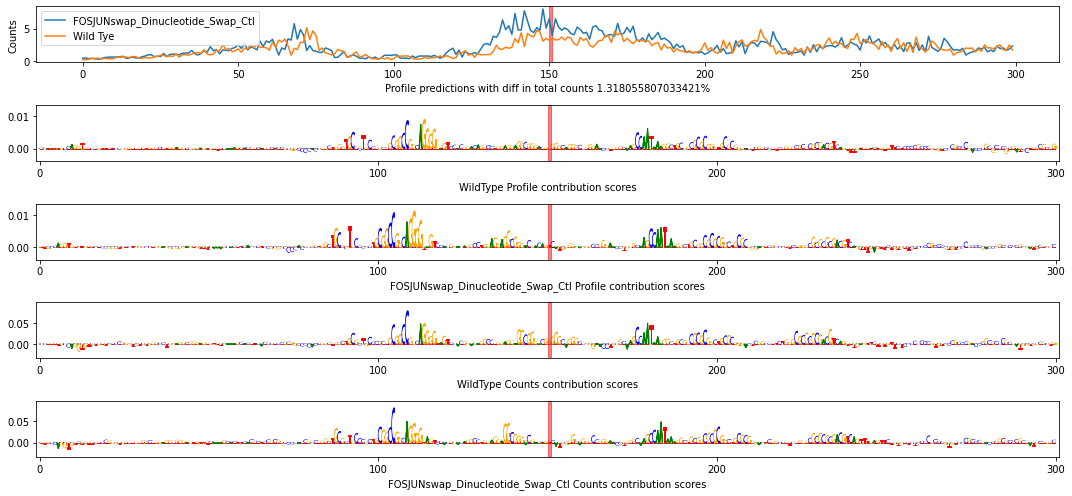

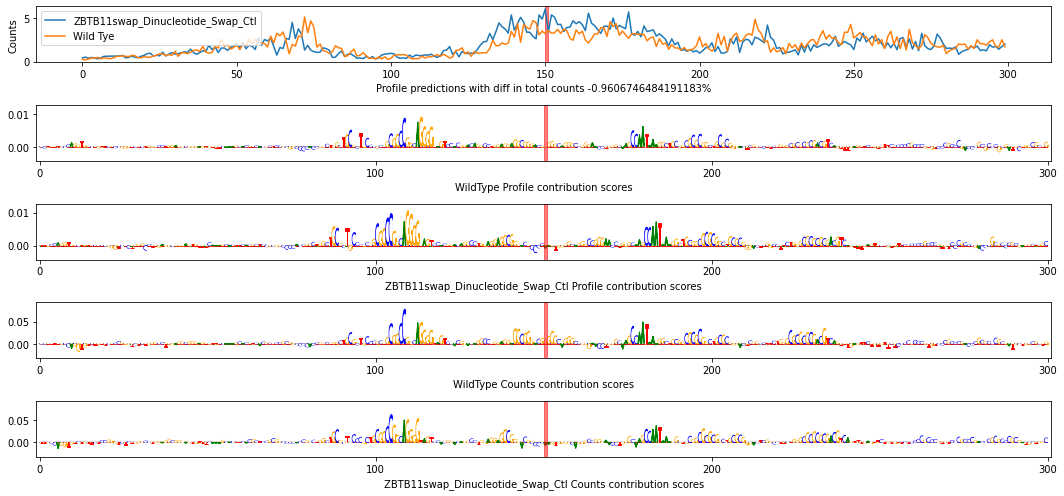

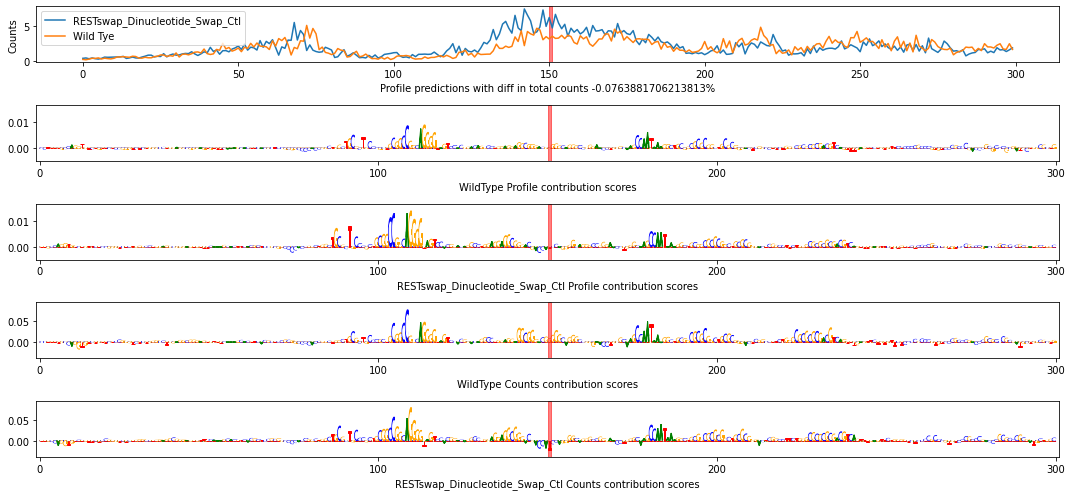

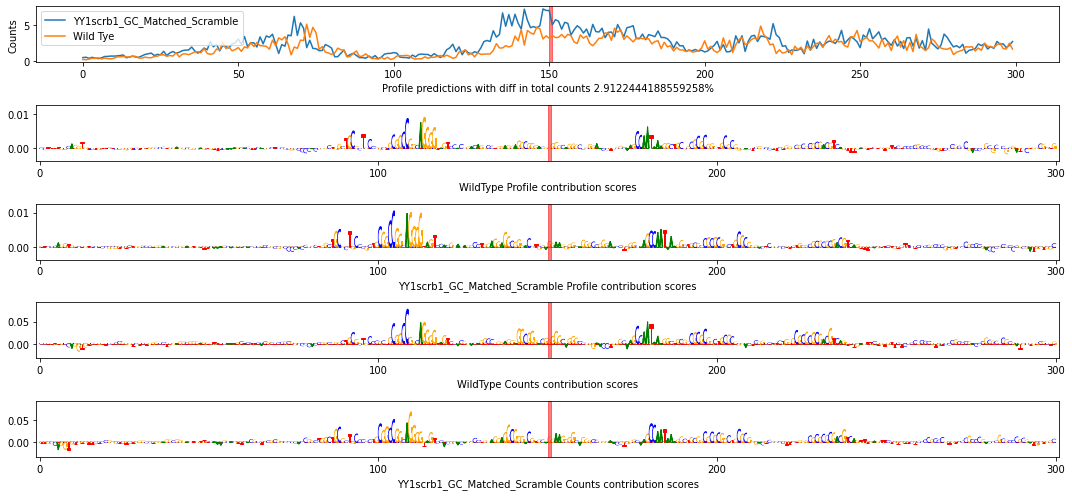

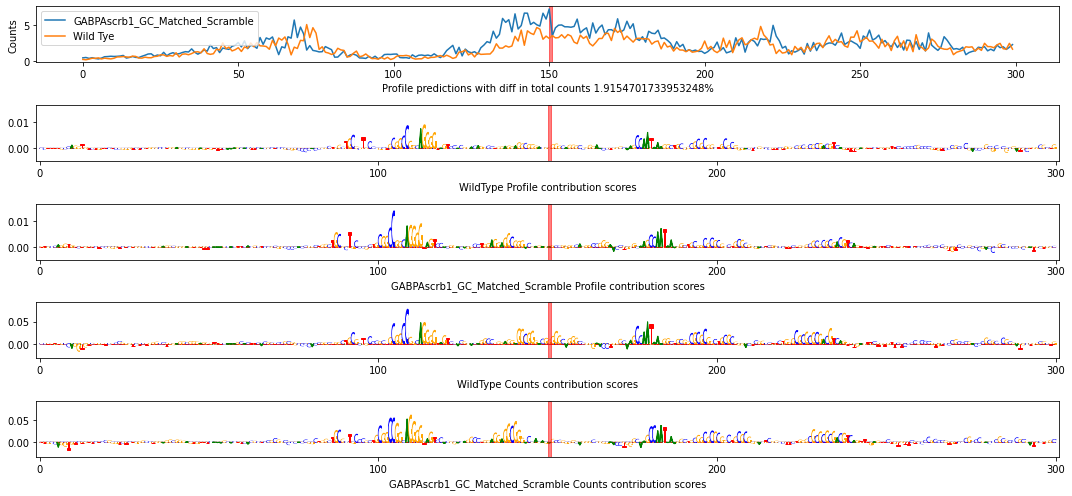

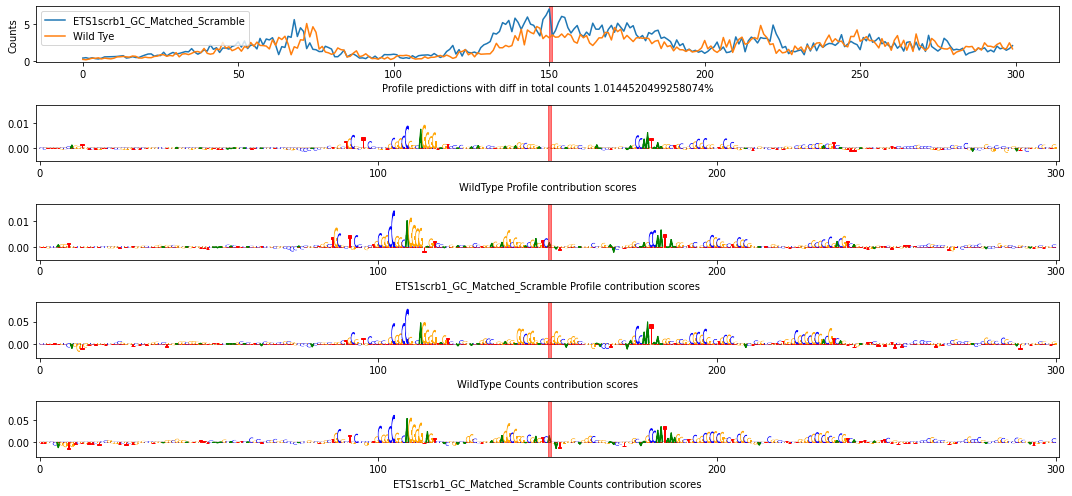

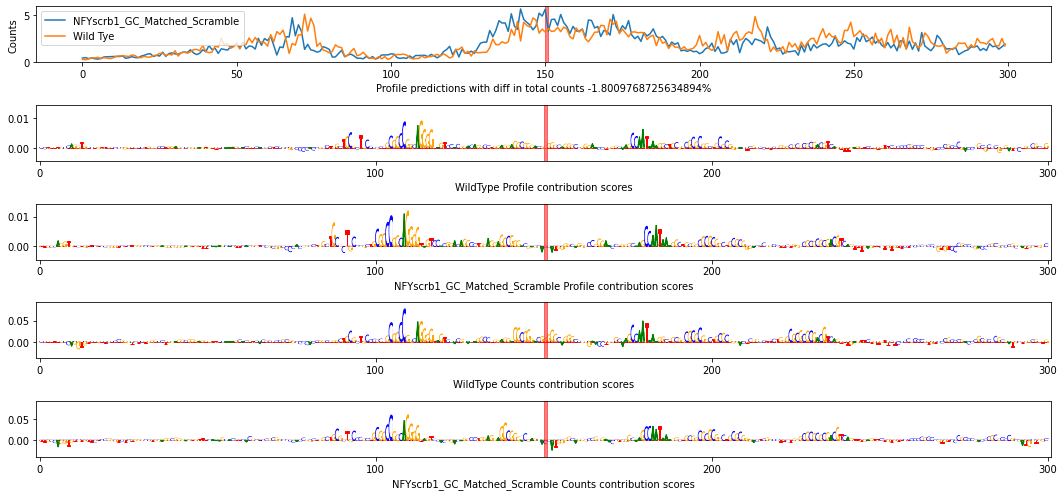

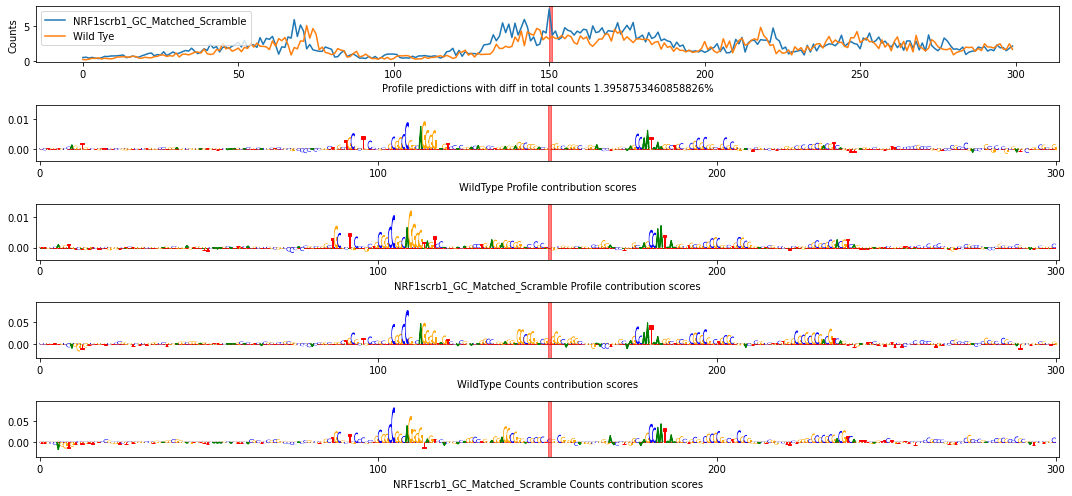

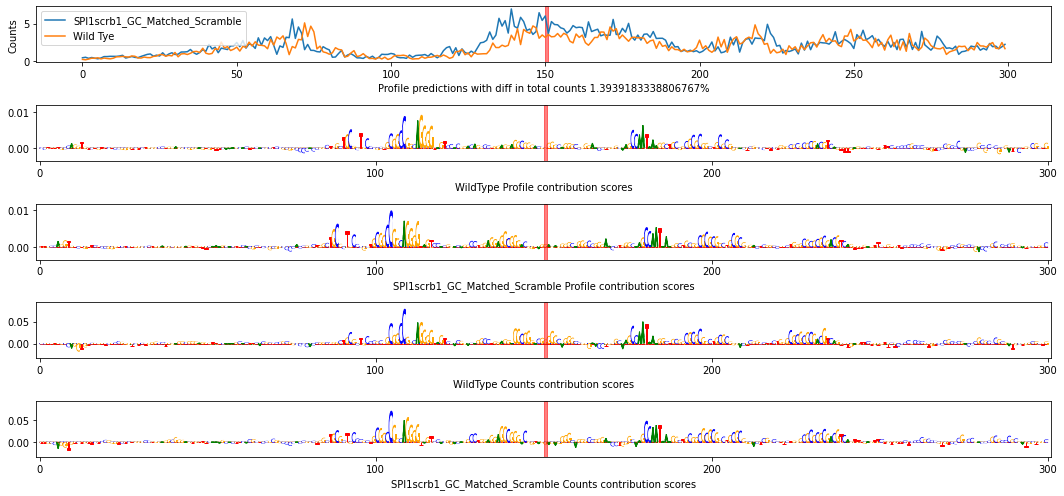

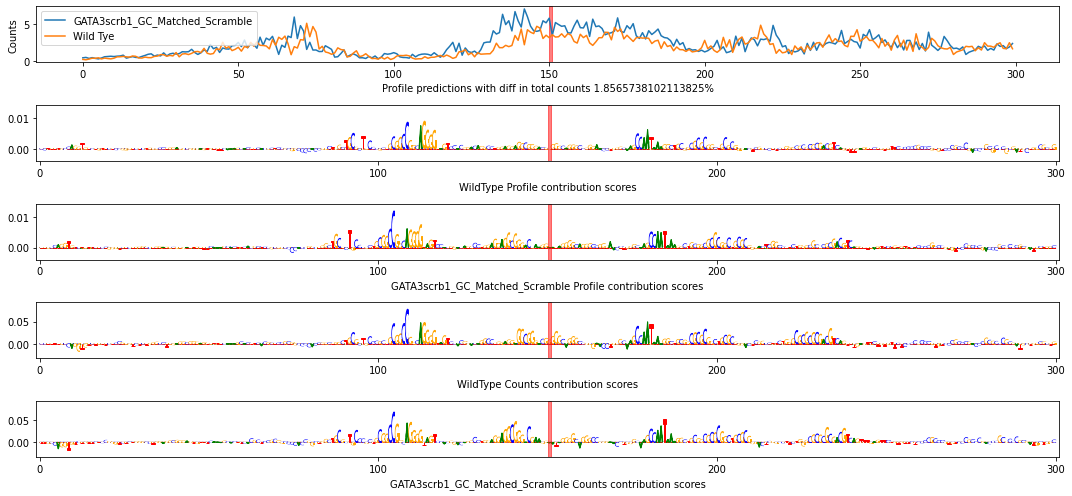

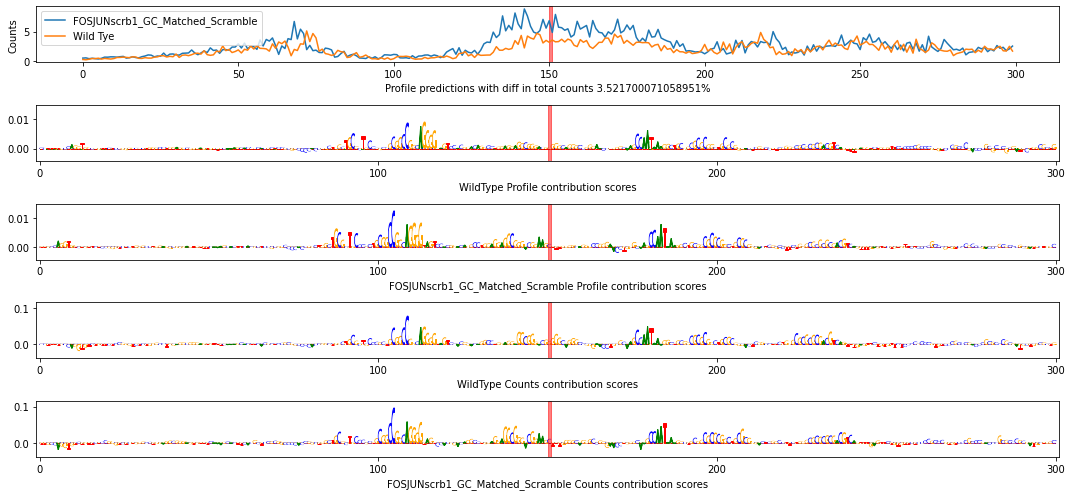

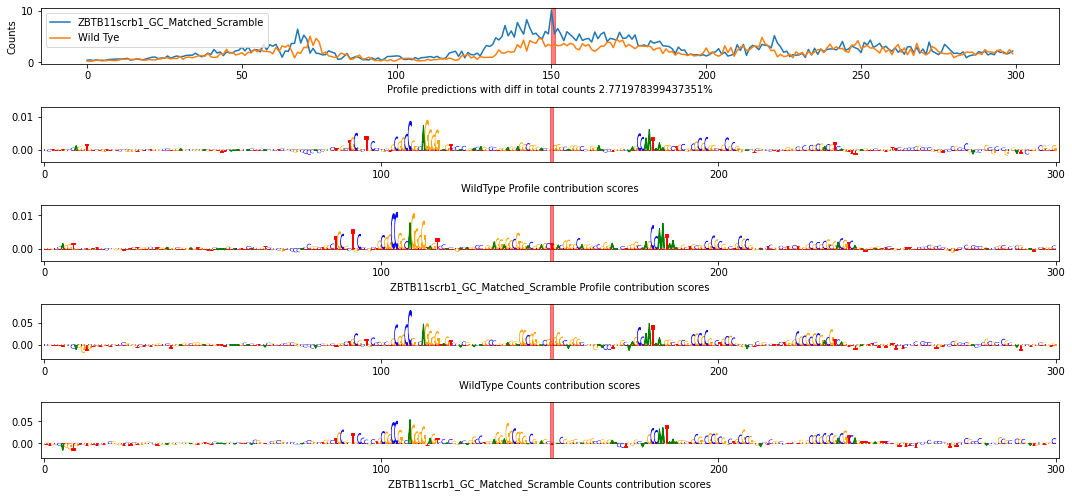

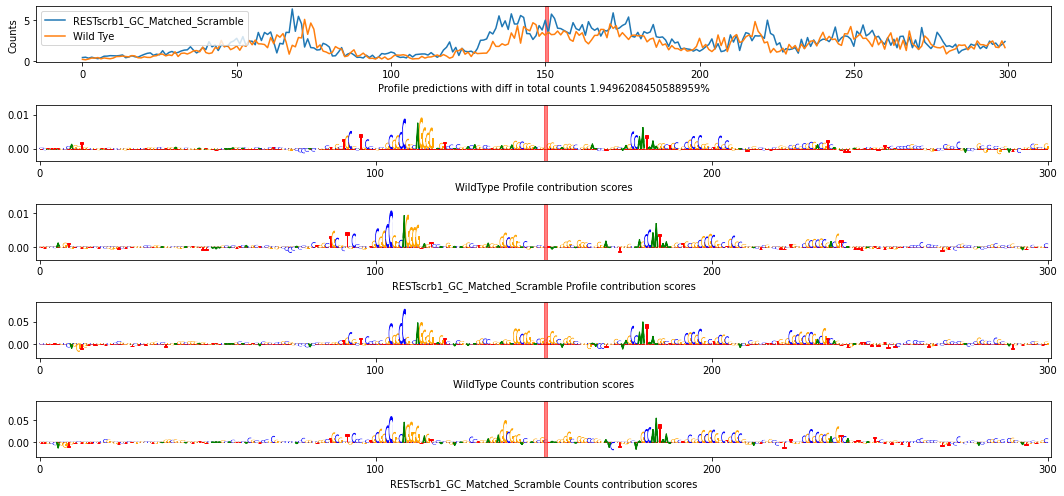

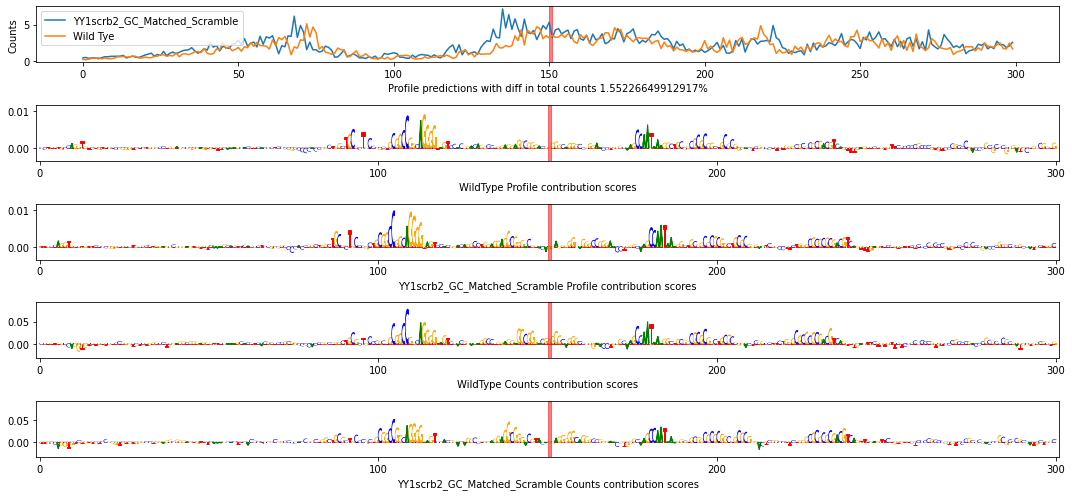

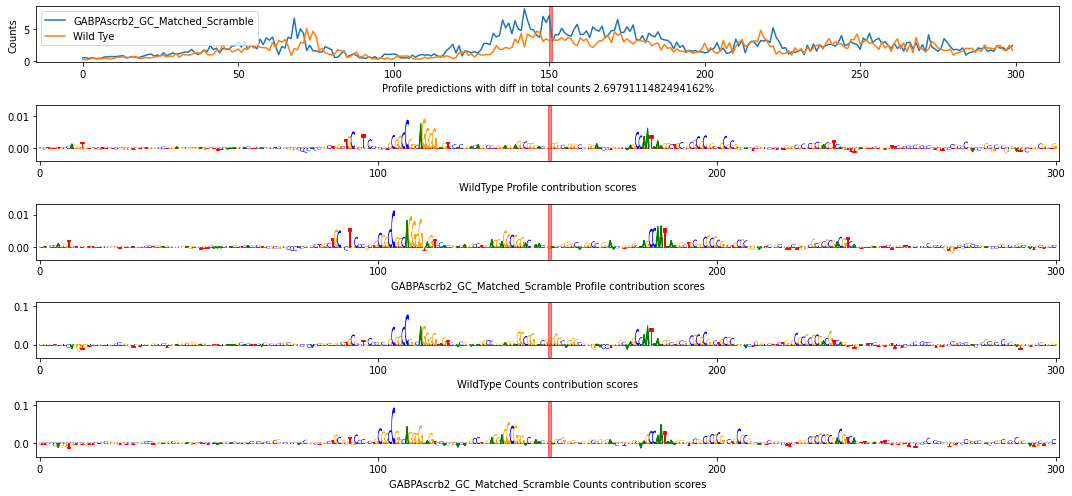

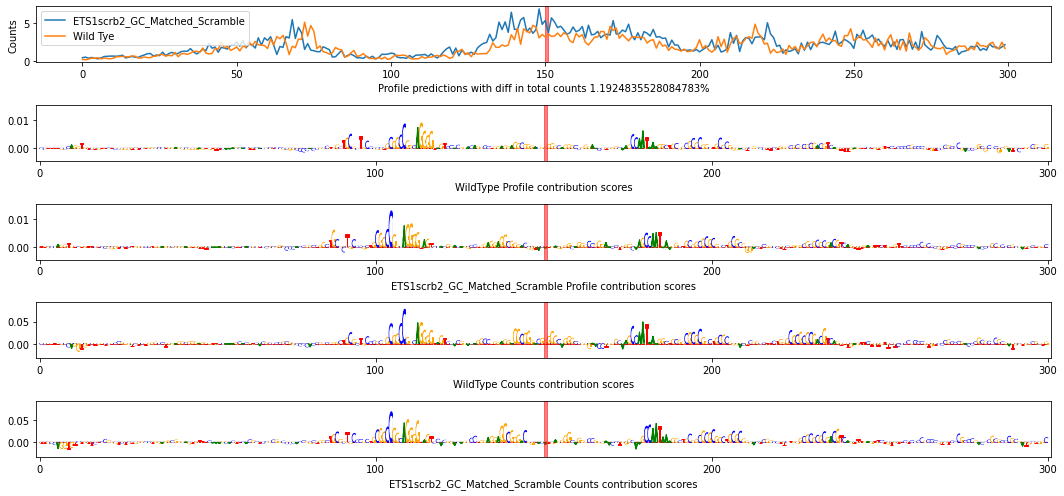

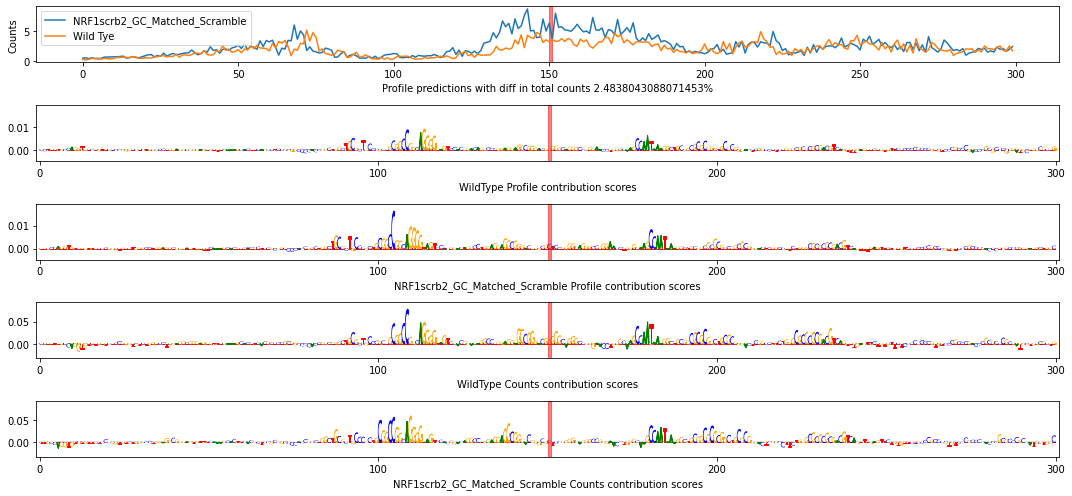

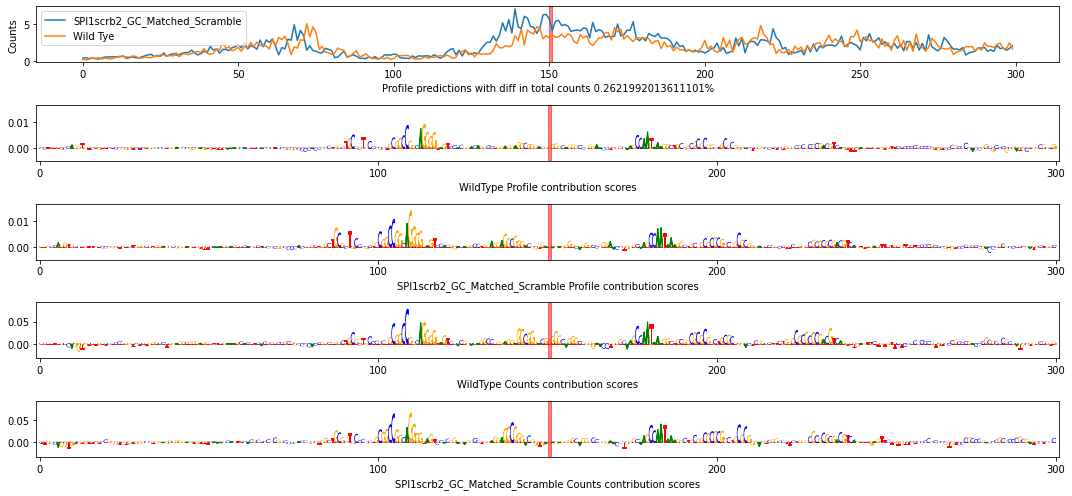

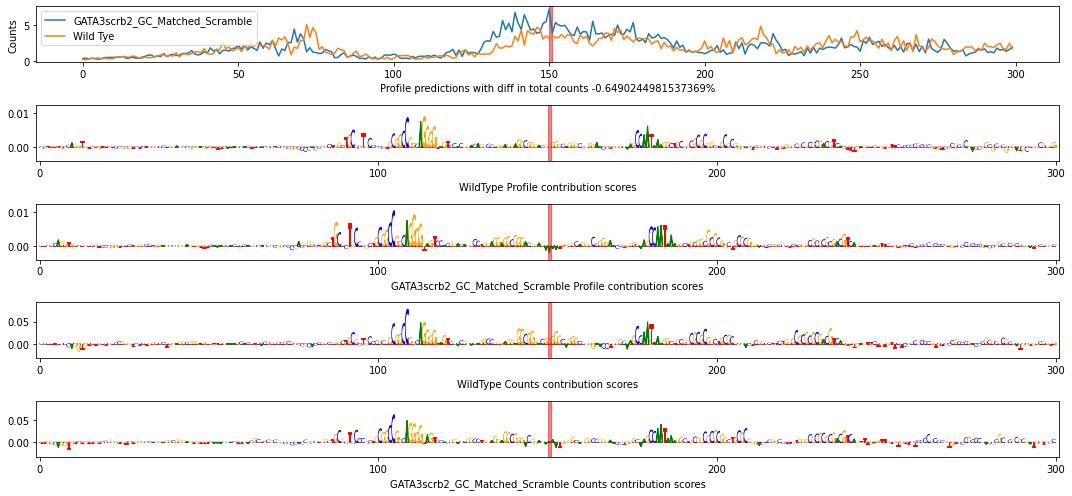

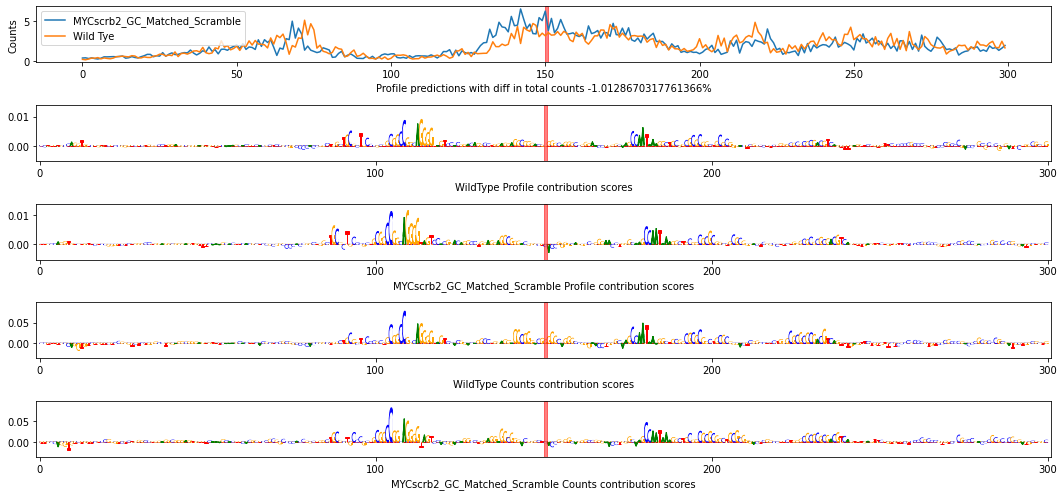

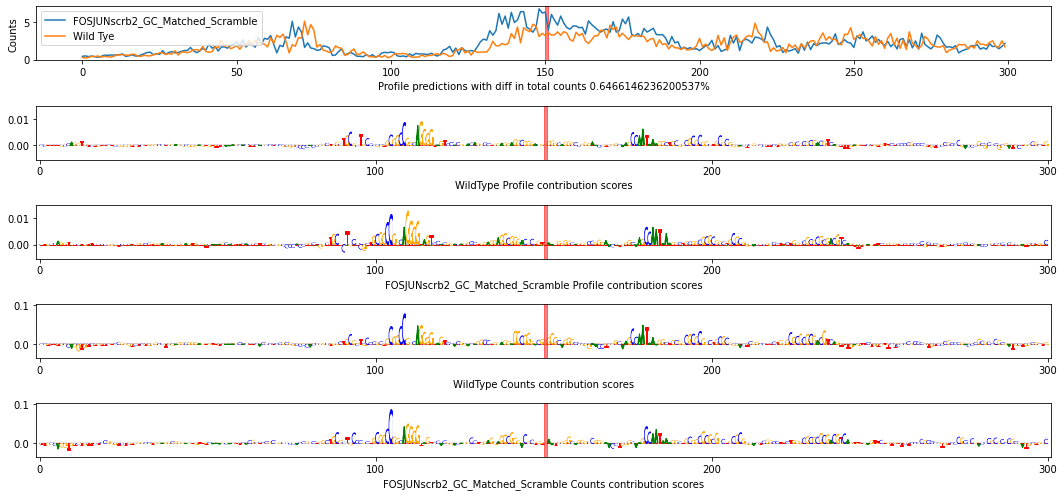

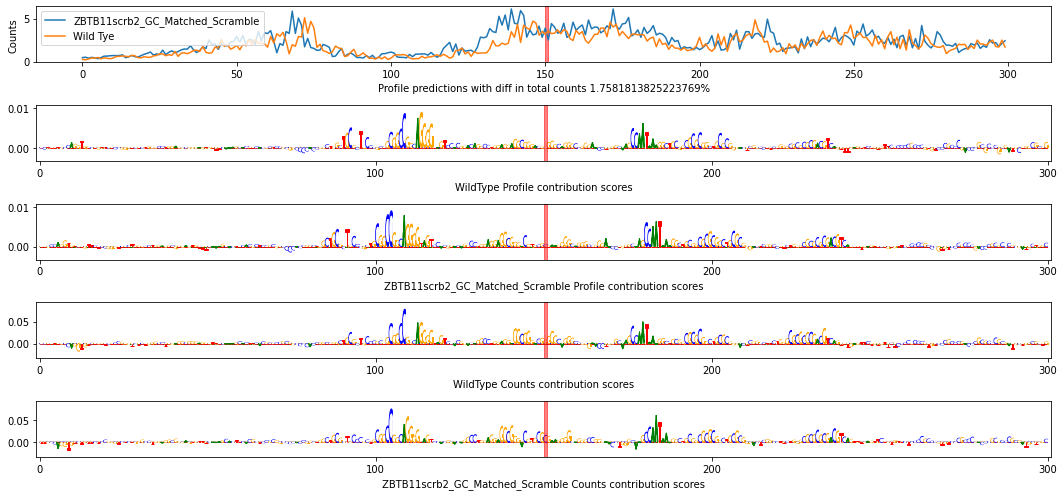

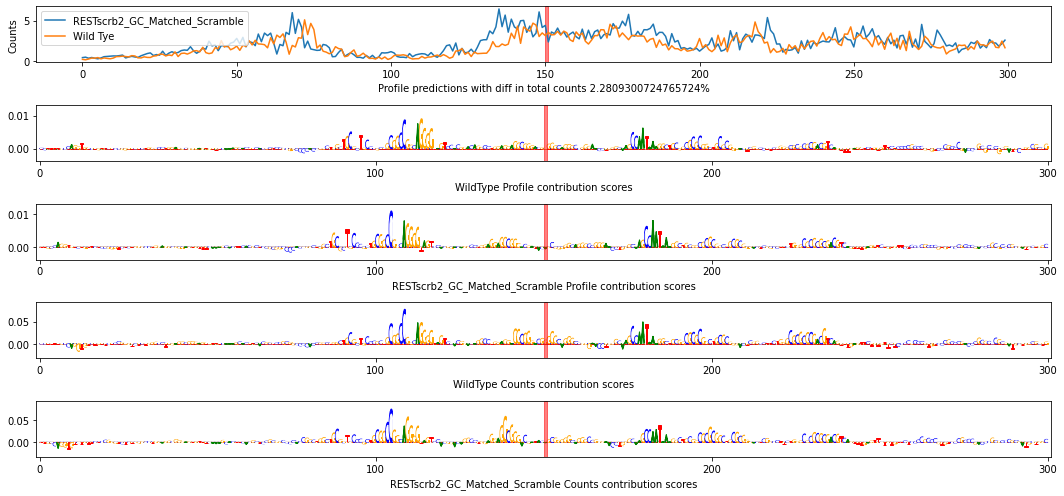

In [40]:

for idx in range(len(data["Motif"].values)):

    fig_name = data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] + "_flank_" + str(flank)+ ".png"

    print(fig_name)
    
    if idx ==0 :
        fig, axs = plt.subplots(3, 1, figsize=(15,5))
        
        axs[0].plot(probs[idx,500-flank:500+flank]*np.exp(output_preds[1][idx]+1))
        axs[0].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[0].set_ylabel('Counts')
        axs[0].set_xlabel('Profile predictions')
        
        last_ax=0
        ytup_p=None
        ytup_c=None    
    else:
        fig, axs = plt.subplots(5, 1, figsize=(15,7))
        print(output_preds[1][0][0])
        print(str((output_preds[1][idx]-output_preds[1][0])[0]*100.0/output_preds[1][0]) + "%")
        axs[0].plot(probs[idx,500-flank:500+flank]*np.exp(output_preds[1][idx]+1), label=data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx])
        axs[0].plot(probs[0,500-flank:500+flank]*np.exp(output_preds[1][0]+1), label="Wild Tye")
        axs[0].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[0].set_ylabel('Counts')
        axs[0].set_xlabel('Profile predictions with diff in total counts '+ str((output_preds[1][idx]-output_preds[1][0])[0]*100.0/output_preds[1][0][0]) + "%")
        axs[0].legend()
        
        pylims_min = min(np.min(profile_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.min(profile_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))
        pylims_max = max(np.max(profile_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.max(profile_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))
        cylims_min = min(np.min(counts_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.min(counts_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))
        cylims_max = max(np.max(counts_scores[0][(input_length // 2) - flank:(input_length // 2) + flank]), np.max(counts_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank]))

        last_ax = 0
        
        viz_sequence.plot_weights_given_ax(ax=axs[last_ax+1], array=profile_scores[0][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=(pylims_min, pylims_max))
        axs[last_ax+1].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[last_ax+1].set_xlabel('WildType Profile contribution scores')

        
        last_ax=1
        ytup_p=(pylims_min, pylims_max)
        ytup_c=(cylims_min, cylims_max)


    viz_sequence.plot_weights_given_ax(ax=axs[last_ax+1], array=profile_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=ytup_p)
    axs[last_ax+1].axvspan(flank, flank+1, color='red', alpha=0.5)
    axs[last_ax+1].set_xlabel(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] + ' Profile contribution scores')

    if idx>0:
        viz_sequence.plot_weights_given_ax(ax=axs[last_ax+2], array=counts_scores[0][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=ytup_c)
        axs[last_ax+2].axvspan(flank, flank+1, color='red', alpha=0.5)
        axs[last_ax+2].set_xlabel('WildType Counts contribution scores') 
        last_ax += 1
    
    viz_sequence.plot_weights_given_ax(ax=axs[last_ax+2], array=counts_scores[idx][(input_length // 2) - flank:(input_length // 2) + flank],
            height_padding_factor=0.2,
            length_padding=1.0,
            subticks_frequency=100,
            colors=viz_sequence.default_colors,
            plot_funcs=viz_sequence.default_plot_funcs,
            highlight={},
            ylabel="",
            ylim=ytup_c)
    axs[last_ax+2].axvspan(flank, flank+1, color='red', alpha=0.5)
    axs[last_ax+2].set_xlabel(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] + ' Counts contribution scores')
    

    fig.tight_layout()
    plt.savefig(odir+fig_name)
    

In [20]:
valuesn = []
for idx in range(len(data["Motif"].values)):
    valuesn.append((output_preds[1][idx]-output_preds[1][0])[0])

jsd_values = []
jsd_names = []
for idx in range(len(data["Motif"].values)):
    #valt = np.sum(np.abs(np.log(probs[idx]) -  np.log(probs[0])))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])
    valt = (distance.jensenshannon(probs[0], probs[idx]))*np.sign((output_preds[1][idx]-output_preds[1][0])[0])

    jsd_values.append(valt)
    jsd_names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

data["diff_in_logcounts_preds"] = valuesn

#data["diff_in_logcounts_preds"] = jsd_values

#data["diff_in_logcounts_preds_percentage_change"] = jsd_values


In [21]:
data.to_csv("pPPIF_Motif_Insertions_2022-03-14_V3_diff_in_log_counts_preds.csv", index=False, header=True, sep=",")

In [22]:
values = []
names = []
for idx in range(len(data["Motif"].values)):
    values.append(((output_preds[1][idx]-output_preds[1][0])[0])*100.0/output_preds[1][0][0])
    names.append(data["Motif"].values[idx] + "_" + data["Edit_Type"].values[idx] )

In [23]:
sorted_dix  = np.argsort(names)

In [24]:
np.array(values)[sorted_dix].tolist()

[3.927028346272797,
 1.0144602187907474,
 1.1924917360705198,
 1.6388442046717928,
 4.466743243536118,
 3.5217246163366216,
 0.646622762738614,
 1.3180720872782228,
 2.5754444439772053,
 1.915470328296102,
 2.6979194532527973,
 4.119672761654979,
 1.185156983121496,
 1.856565873521364,
 -0.6490164638112832,
 2.7427770878815,
 1.430478995758297,
 -1.0128590268570026,
 0.7599515696047838,
 3.020826493224694,
 -1.8009527577215458,
 0.7936412948370132,
 3.5620374536584323,
 1.3958592853120237,
 2.4838125964960747,
 0.6858277046315204,
 -0.20319772585459173,
 1.9496290895493276,
 2.280938343759411,
 -0.07637200314286481,
 2.771824973871459,
 1.3939265334324025,
 0.2622073093926566,
 2.1582773374410107,
 0.0,
 -0.12421367728445612,
 2.912228480708225,
 1.5522747114862392,
 4.353770257099669,
 4.745269771728255,
 2.7720028840863193,
 1.7581896115314284,
 -0.960666639279276]

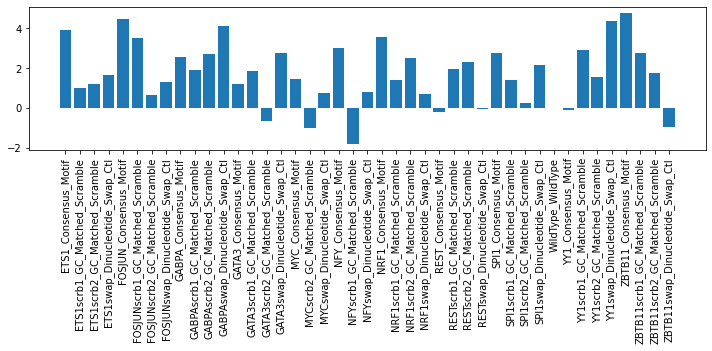

In [25]:
bars_label=np.array(names)[sorted_dix].tolist()
bars_heights=np.array(values)[sorted_dix].tolist()
plt.figure(figsize=(10,5))
plt.bar(range(len(bars_label)), bars_heights)
plt.xticks(range(len(bars_label)), bars_label, rotation='vertical')
plt.tight_layout()
plt.show()

In [26]:
data["diff_in_logcounts_preds_percentage_change"] = values

In [27]:
data.to_csv("pPPIF_Motif_Insertions_2022-03-14_V3_diff_in_log_counts_preds_with_percentage.csv", index=False, header=True, sep=",")

In [28]:
data_v = pd.read_csv("AllelicEffects.byExperimentRep.ExperimentIDReplicates.flat_MTM.csv").dropna(how="all").dropna(axis=1,how="all")

In [29]:
data_v.head()

AmpliconID     MappingSequence VariantID  RefAllele            A  \
0      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3231.546560   
1      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3846.655830   
2      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3197.413131   
3      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3417.124609   
4      pPPIF  GGACGCAGGAAGTGGGGC     ETS1i      False  3352.489164   

             B            C            D            E            F  ...  \
0  3146.027783  3762.638226  3592.167517  3960.802340  4342.238428  ...   
1  3551.304650  3993.984855  4368.383358  4503.364634  4552.966963  ...   
2  3524.494671  3948.896351  3705.707460  4330.685787  4215.387007  ...   
3  3234.679703  4117.421454  4212.252011  4217.047643  4476.286056  ...   
4  3786.532800  4346.479146  4339.655967  4982.311444  4613.633106  ...   

          sum1  WeightedAvg   logMean     logSD        mean      freq  \
0  22035.42086     2.411260  2.419521  0.368955  307.315647  0.007597   
1  24816.66029     2.336749  2.344050  0.382112  261.249206  0.007710   
2  22922.58441     2.321270  2.334486  0.379902  255.063745  0.007554   
3  23674.81148     2.522481  2.523198  0.365576  389.064025  0.008162   
4  25421.10163     2.594442  2.589170  0.342836  444.568041  0.008222   

   effect_size  pct_change  ExperimentIDReplicates  BioRep  
0     1.080658    8.065764                 1-nan-1       1  
1     1.030202    3.020201                 1-nan-2       1  
2     1.052826    5.282624                 1-nan-3       1  
3     1.072778    7.277834                 2-nan-1       2  
4     1.047798    4.779761                 2-nan-2       2  

[5 rows x 22 columns]